This code implements a 10-fold cross-validation procedure using penalized regression to predict a continous variable. It further extracts the features retained across models and their beta-coefficients

The code was used to generate a ML(LASSO) model predicting gut microbiome alpha-diversity from 
blood metabolomics data, the published paper can be found [here](https://www.nature.com/articles/s41587-019-0233-9).



In [1]:
# Load libraries
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# run_LASSO_model() function takes as input a dataframe with all the features and the outcome variable (df),
# the name of the outcome variable(outcome), 
# the number of cross-validations (CV) you want to perform,
# as well as the eps parameter that specifies the search space for the penalty parameter alpha in the LASSO objective function

#The function then returns 4 values: 
    #1)the out-of-sample r2 for each fold (list)
    #2)out-of-sample predictions for each individual (liist)
    #3)The beta-coefficient for each metabolite in each of the models (df)
    #4)the L1 regularization parameter for each model (list)
    
def run_LASSO_model(df,outcome,CV=10,eps=0.1):
    #specify feature table excluding the outcome variable
    X = df.loc[:, df.columns!=outcome]
    #scale and standardize the feature table
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    Xcolumns=X.columns
    X = scaler.fit_transform(X)
    X=pd.DataFrame(data=X,columns=Xcolumns)
    print('feature table shape',X.shape)
    print('outcome variable=',outcome, 'CV=',CV,'eps=',eps)
    y=df[outcome]
    ind=y.index.name
    y=y.reset_index()
    y.drop([ind],1,inplace=True)
    #split data into CV folds
    X_folds = np.array_split(X, CV)
    y_folds = np.array_split(y, CV)
    coefficients=pd.DataFrame(index=X.columns).astype('float64')
    predictions=[]
    alphas= []
    score= []
    #run LASSO using the scikit-Learn LASSOCV function
    lassocv=LassoCV(eps=eps, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=CV)
    print('starting cross-validation procedure...')
    for k in range(CV):
        X_train = list(X_folds)
        X_test  = X_train.pop(k)
        X_train = np.concatenate(X_train)
        y_train = list(y_folds)
        y_test  = y_train.pop(k)
        y_test=[ x[0] for x in  list(y_test.values)]
        y_train = np.concatenate(y_train)
        lassocv.fit(X_train, y_train)
        predictions.append(lassocv.predict(X_test).flatten())
        coef=list(lassocv.coef_)
        coefficients[k]=coef
        alphas.append(lassocv.alpha_)
        r2=r2_score(y_test,lassocv.predict(X_test))
        score.append(r2)
        print('CV-fold {},test set r2={}'.format(k+1,round(r2,3)))
    predictions_lasso=[item for sublist in predictions for item in sublist]
    print('Done!')
    return score,predictions_lasso,coefficients,alphas
    

In [3]:
#Load data file containing predictors and a continous outcome variable
#see original publication for data access options
data=pd.read_csv('metabolomics.csv')
#set index
data.set_index('public_client_id',inplace=True)
#check shape
print (data.shape)
#dataframe contains 659 features and an outcome variable 
#(Shannon diversity, a measure of how diverse is your gut microbiome)

(399, 660)


In [4]:
#run a 10-fold CV implementation of LASSO to predict gut alpha diversity(shannon diversity)
results=run_LASSO_model(data,outcome='shannon',eps=0.175)

feature table shape (399, 659)
outcome variable= shannon CV= 10 eps= 0.175
starting cross-validation procedure...
CV-fold 1,test set r2=0.397
CV-fold 2,test set r2=0.466
CV-fold 3,test set r2=0.295
CV-fold 4,test set r2=0.495
CV-fold 5,test set r2=0.54
CV-fold 6,test set r2=0.51
CV-fold 7,test set r2=0.213
CV-fold 8,test set r2=0.533
CV-fold 9,test set r2=0.502
CV-fold 10,test set r2=0.527
Done!


In [5]:
#evaluating  model performance across the 10-fold CV:
print('mean out-of-sample R2(std.dev)={}({})'.format(round(np.mean(results[0]),3),round(np.std(results[0]),3)))
corr=stats.spearmanr(results[1], data['shannon'])
print('correlation of predicted versus observed values,Spearman rho={},p-value={}'.format(round(corr[0],3),corr[1]))

mean out-of-sample R2(std.dev)=0.448(0.106)
correlation of predicted versus observed values,Spearman rho=0.689,p-value=1.988714742248397e-57


In [6]:
#exploring top features: a function that takes the output of run_LASSO_model() and identifies features with non-zero Beta-coefficients
#in at least one of the LASSO models generated. It also calculates basic statitistics for each beta-coefficient
def feature_extraction(model_results=results):
    feat=model_results[2].copy()
    print('total no. of features trained on={}'.format(feat.shape[0]))
    #drop all metabolites that were not retained by at least one LASSO model
    for x in feat.index.tolist():
        if (feat.loc[x] == 0.0).sum()==len(feat.columns):
            feat.drop([x],inplace=True)   
    #calculate the mean, std, and number of models in which the metabolites was not retained
    means=[]
    std=[]
    zeroes=[]
    for x in feat.index.tolist():
        means.append((np.mean(feat.loc[x])))
        std.append((np.std(feat.loc[x])))
        zeroes.append((feat.loc[x] == 0.0).astype(int).sum())
    feat['mean']=means
    feat['std_dev']=std
    feat['zeroes']=zeroes
    print('total no. features retained in at least one model={}'.format(feat.shape[0]))
    print ('total no. of features retained by all {} models={}'.format(results[2].shape[1],feat[feat['zeroes']==0].shape[0]))
    #return a new df containing only features retained by at least one LASSO model
    return feat

In [7]:
#identify top features from our metabolomics models
met_features=feature_extraction(results)

total no. of features trained on=659
total no. features retained in at least one model=40
total no. of features retained by all 10 models=11


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


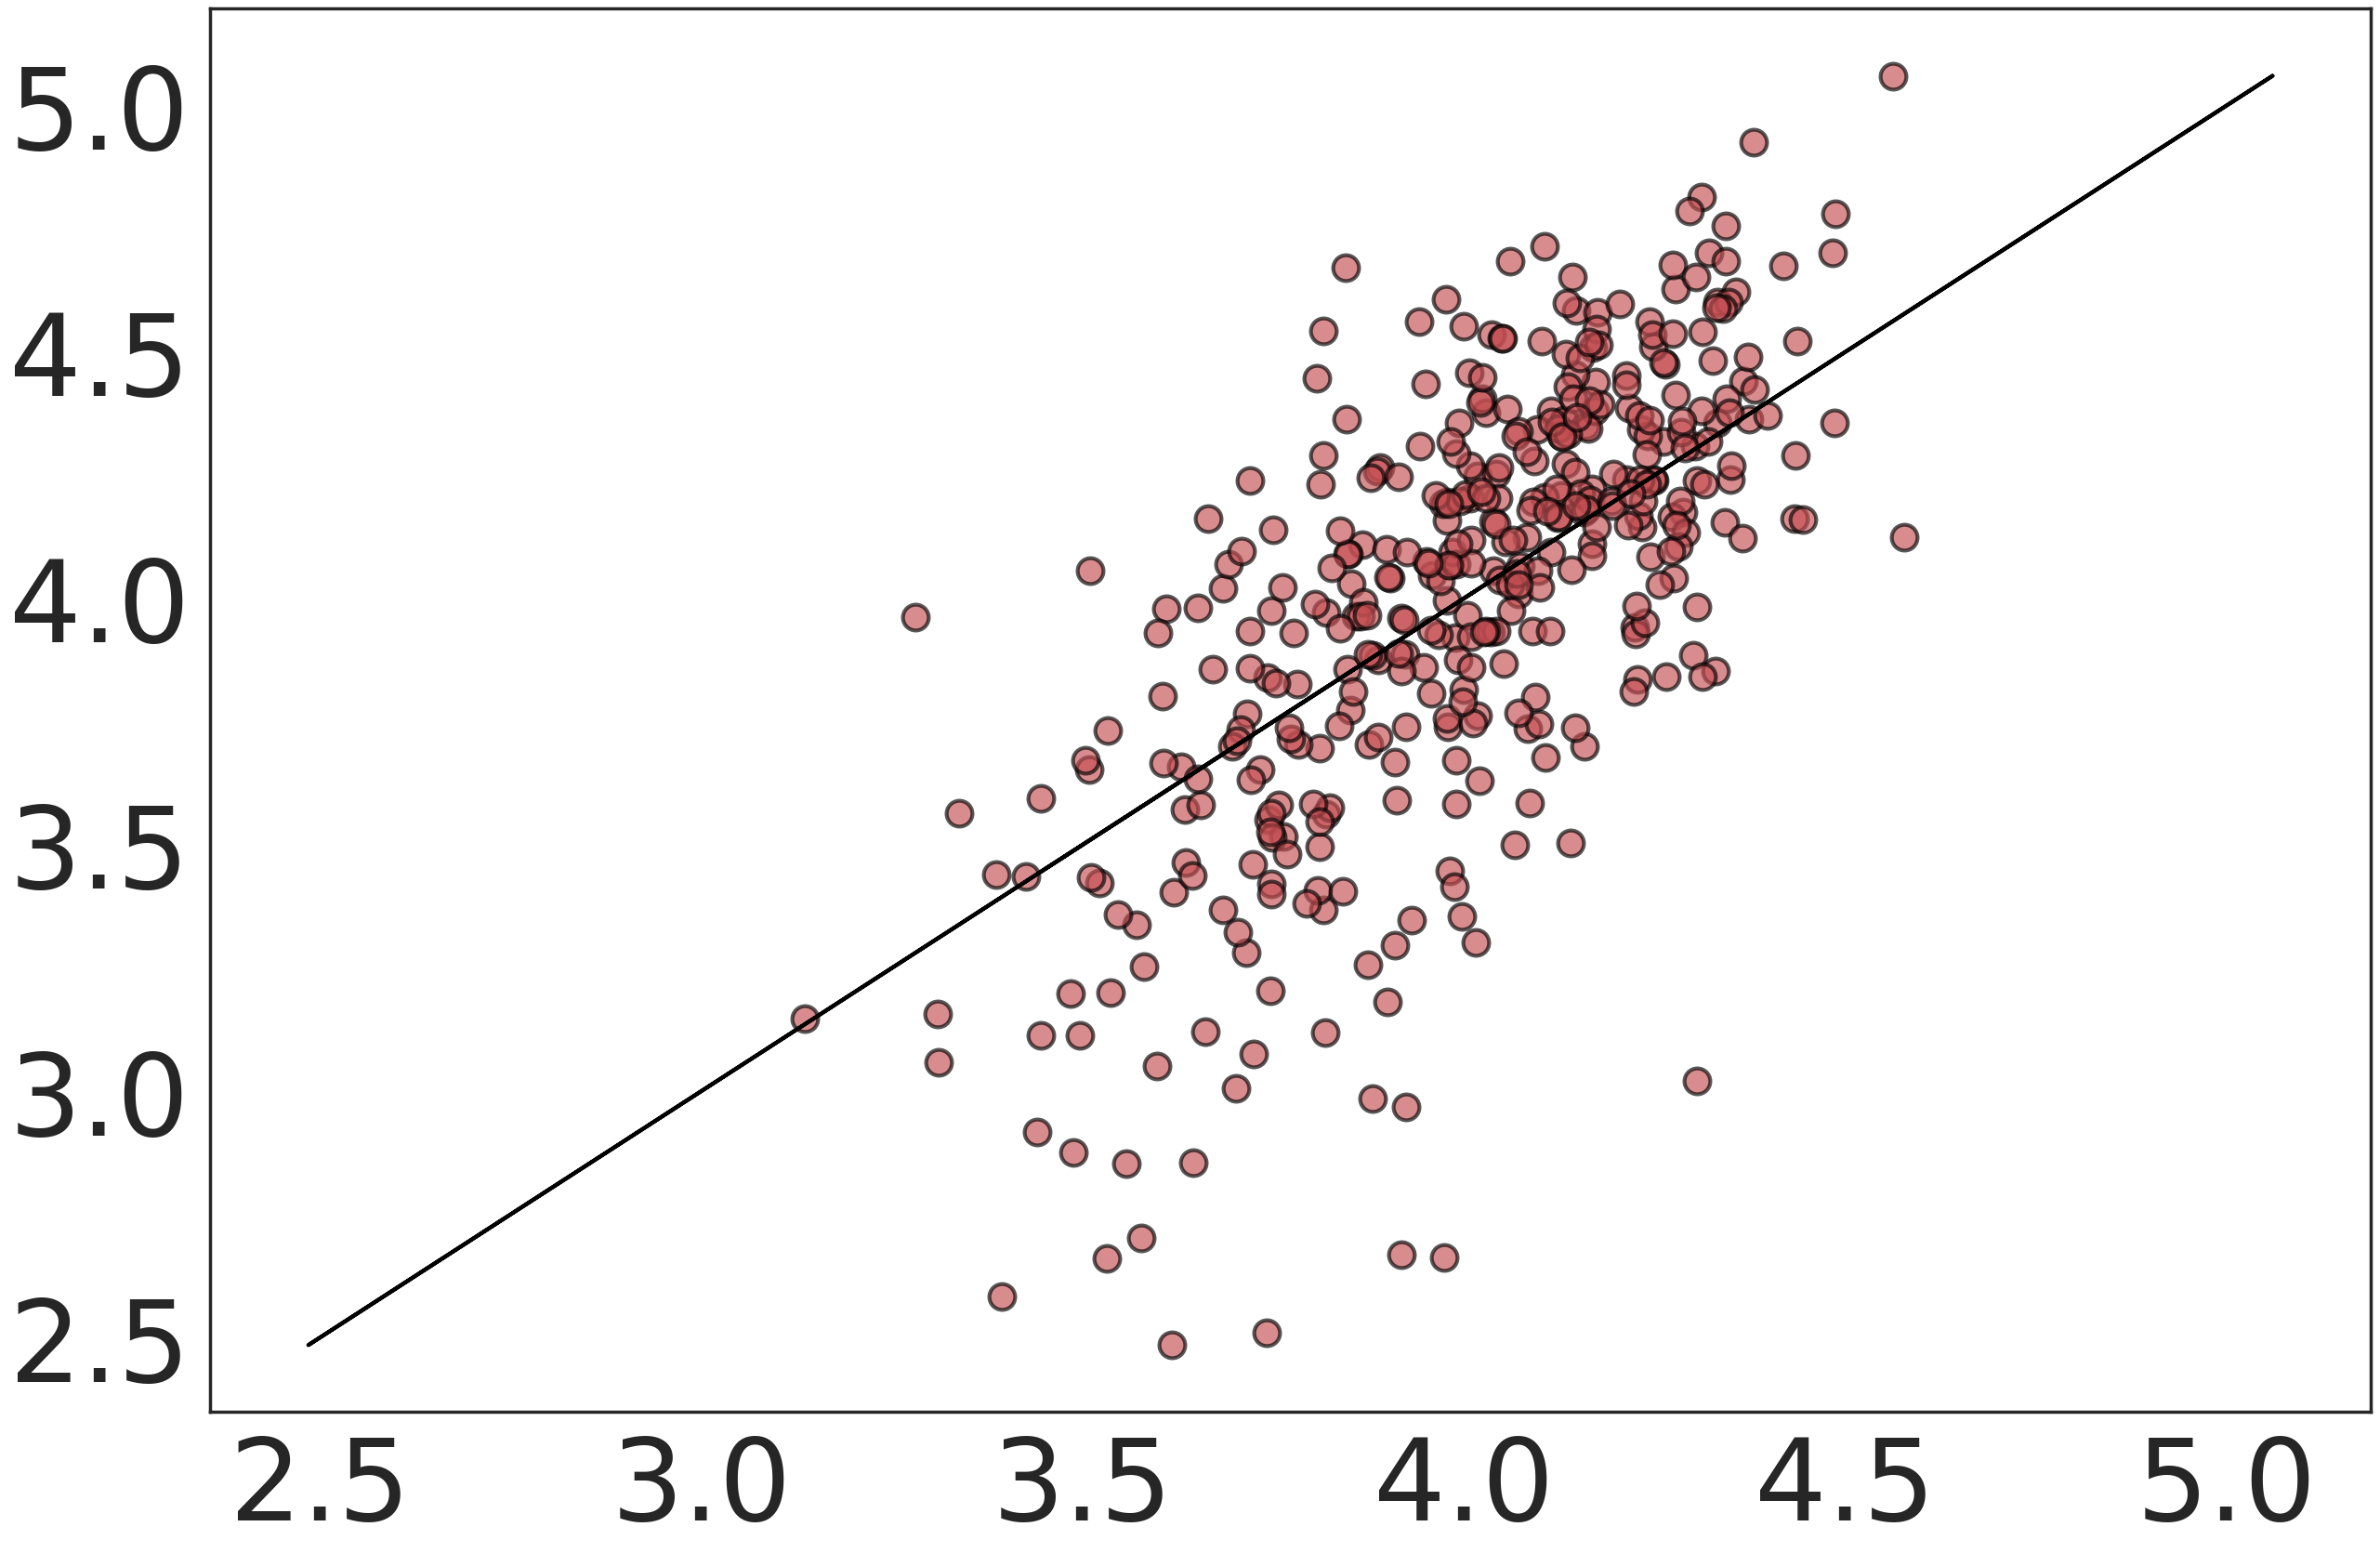

In [8]:
#how do our out-of-sample predictions compare to observed values
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.scatter(results[1], data['shannon'],s=400,color='r',alpha=0.65,linewidth=3,edgecolors='black')
plt.plot(data['shannon'],data['shannon'],color='black')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


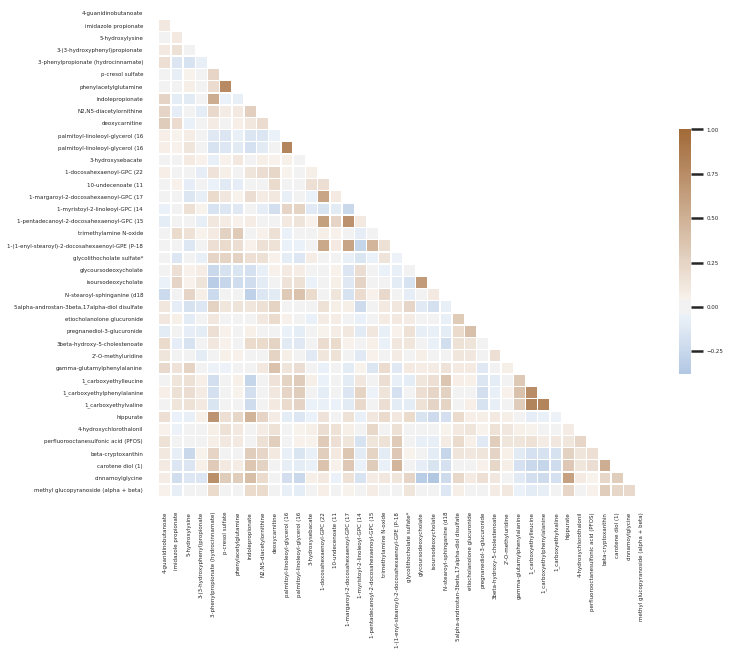

In [9]:
#How about collinearity among the predictor variables? LASSO should select mostly orthogonal features
#but let's see if that is the case by generating a correlation heatmap

#Select only the mets retained by LASSO for correlation
corr_df=pd.DataFrame(index=data.index)
for x in met_features.index.tolist():
    corr_df[x]=data[x]
#Change metabolite names to just the name (no family, subfamily)
corr_df.columns=list([x.split(":")[0].split(".")[-1] for x in corr_df.columns.tolist()])
# Compute the correlation matrix
corr = corr_df.corr('spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(font_scale=0.25,context='poster',font='Arial',style='white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 40, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap
#plt.savefig('heatmap_40_.png',dpi=200)